In [1]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO

### NREL Bird Model implementation: for obtaining clear sky GHI

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_color_codes()

In [4]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [5]:
pns = Location(40.798,-77.859, 'US/Eastern', 351.74, 'Penn State')

In [6]:
times2009 = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',
                        tz=pns.tz)   # 12 months of 2009 - For testing
times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                        tz=pns.tz)   # 24 months of 2010 and 2011 - For training

In [7]:
cs_2009 = pns.get_clearsky(times2009) 
cs_2010and2011 = pns.get_clearsky(times2010and2011) # ineichen with climatology table by default
#cs_2011 = bvl.get_clearsky(times2011) 

In [8]:
cs_2009.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
#cs_2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns

In [9]:
cs_2009.reset_index(inplace=True)
cs_2010and2011.reset_index(inplace=True)
#cs_2011.reset_index(inplace=True)

In [10]:
cs_2009['index']=cs_2009['index'].apply(lambda x:x.to_datetime())
cs_2009['year'] = cs_2009['index'].apply(lambda x:x.year)
cs_2009['month'] = cs_2009['index'].apply(lambda x:x.month)
cs_2009['day'] = cs_2009['index'].apply(lambda x:x.day)
cs_2009['hour'] = cs_2009['index'].apply(lambda x:x.hour)
cs_2009['min'] = cs_2009['index'].apply(lambda x:x.minute)

In [11]:
cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)

In [12]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525601, 7)
(1051201, 7)


In [13]:
cs_2009.drop(cs_2009.index[-1], inplace=True)
cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
#cs_2011.drop(cs_2011.index[-1], inplace=True)

In [14]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525600, 7)
(1051200, 7)


In [15]:
cs_2010and2011.head()

,index,ghi,year,month,day,hour,min
0,2010-01-01 00:00:00-05:00,0.0,2010,1,1,0,0
1,2010-01-01 00:01:00-05:00,0.0,2010,1,1,0,1
2,2010-01-01 00:02:00-05:00,0.0,2010,1,1,0,2
3,2010-01-01 00:03:00-05:00,0.0,2010,1,1,0,3
4,2010-01-01 00:04:00-05:00,0.0,2010,1,1,0,4


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [16]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [17]:
path = r'.\\data\\Penn_State\\Exp_1_train'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
df_big_train.shape

(1049577, 48)

In [18]:
path = r'.\\data\\Penn_State\\Exp_1_test'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
df_big_test.shape

(524846, 48)

In [19]:
df_big_test[df_big_test['dw_solar']==-9999.9].shape

(12, 48)

### Merging Clear Sky GHI And the big dataframe

In [20]:
df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
df_train.shape

(1049577, 50)

In [21]:
df_test = pd.merge(df_big_test, cs_2009, on=['year','month','day','hour','min'])
df_test.shape

(524846, 50)

In [22]:
df_train.drop(['index'],axis=1, inplace=True) #updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'], axis=1, inplace=True)

In [23]:
df_train.shape

(1049577, 49)

### Managing missing values

In [24]:
# Resetting index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [25]:
# Dropping rows with two or more -9999.9 values in columns

In [26]:
# Step1: Get indices of all rows with 2 or more -999
missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0]
# Step2: Drop those indices
df_train.drop(missing_data_indices, axis=0, inplace=True)
# Checking that the rows are dropped
df_train.shape

(1039363, 49)

In [27]:
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
df_test.shape

(510853, 49)

In [28]:
# For the rows with only one cell as -9999.9, replacing this cell with the mean of the column

#### First resetting index after dropping rows in the previous part of the code

In [29]:
# 2nd time - Reseting Index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [30]:
one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [31]:
len(one_miss_train_idx)

13173

In [32]:
df_train.shape

(1039363, 49)

In [33]:
col_names = df_train.columns
from collections import defaultdict
stats = defaultdict(int)
total_single_missing_values = 0
for name in col_names:
    col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_train[name] == -9999.9))
    stats[name] = len(missing_indices[0])
    df_train[name].loc[missing_indices] = col_mean
    total_single_missing_values += sum(df_train[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
df_col_min = df_train.apply(min, axis=0)
df_col_max = df_train.apply(max, axis =0)
#print(df_col_min, df_col_max)

In [35]:
train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [36]:
len(train)

0

In [37]:
# doing the same thing on test dataset

In [38]:
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)

6448

In [39]:
col_names_test = df_test.columns
from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]

In [41]:
len(test)

0

In [42]:
df_train.shape

(1039363, 49)

In [43]:
df_test.shape

(510853, 49)

### Exploratory Data Analysis

In [44]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

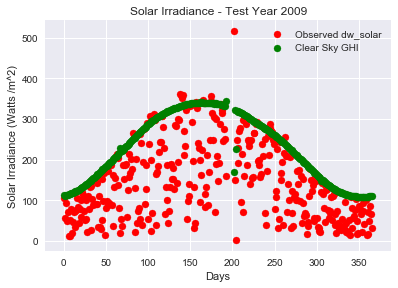

In [45]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
#axes2 = fig.add_axes([0.1,0.1,0.8,0.8])

axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('Figure2a.png', bbox_inches = 'tight')

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


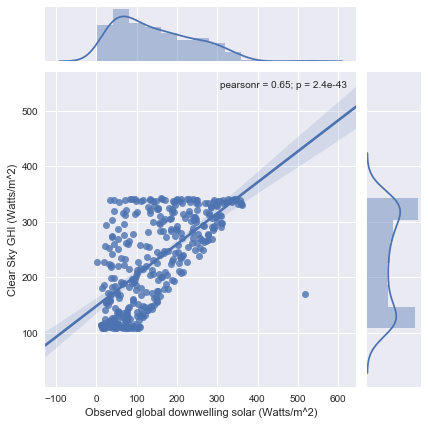

In [46]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
#plt.title('observed dw_solar vs clear sky ghi')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('Figure3a.png', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [47]:
df_train = df_train[df_train['ghi']!=0]
df_test = df_test[df_test['ghi']!=0]
df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']

In [48]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [49]:
print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))
print("\n")
print("train Kt max: "+str(df_train['Kt'].max()))
print("train Kt min: "+str(df_train['Kt'].min()))
print("train Kt mean: "+str(df_train['Kt'].mean()))

test Kt max: 15152.440011618102
test Kt min: -34.79740973618779
test Kt mean: 1.9145243277345676


train Kt max: 110113.08976621665
train Kt min: -167.27791726909712
train Kt mean: 2.453877360947302


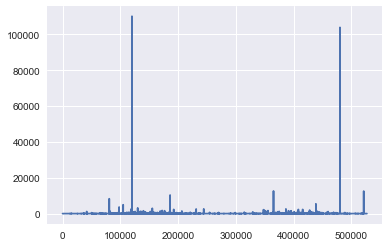

In [50]:
plt.plot(df_train['Kt'])

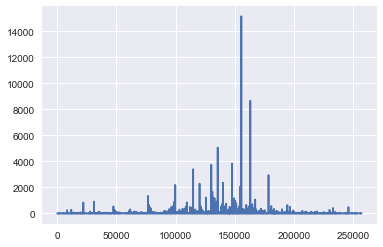

In [51]:
plt.plot(df_test['Kt'])

In [52]:
df_train= df_train[df_train['Kt']< 5000]
df_train= df_train[df_train['Kt']> -1000]
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

#### Group the data (train dataframe)

In [53]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()

In [54]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt], axis=1)

In [55]:
df_new_train.head()

zen  dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                       
2010.0 1.0   1.0 7.0   143.425455 -1.595455  0.000000  2.354545 -0.481818   
                 8.0   135.844000 -1.611667  0.000000  2.188333 -0.465000   
                 9.0   124.525667 -1.760000 -0.013333  2.090000 -0.393333   
                 10.0  113.255500 -1.645000 -0.045000  3.075000 -0.441667   
                 11.0  102.321167 -1.561667 -0.045000  3.716667 -0.470000   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 7.0   294.027273   272.977273   272.813636  303.809091   
                 8.0   293.376667   272.786667   272.631667  303.080000   
                 9.0   299.085000   272.953333   272.795000  305.198333   
                 10.0  298.563333   273.190000   273.025000  305.490000   
                 11.0  306.001667   273.680000   273.568333  308.616667   

                       uw_casetemp    ...     netsolar     netir  totalnet  \
year   month day hour                 ...                                    
2010.0 1.0   1.0 7.0    270.872727    ...          0.0 -9.786364 -9.786364   
                 8.0    270.731667    ...          0.0 -9.711667 -9.711667   
                 9.0    270.860000    ...          0.0 -6.116667 -6.116667   
                 10.0   271.108333    ...          0.0 -6.930000 -6.930000   
                 11.0   271.521667    ...          0.0 -2.611667 -2.611667   

                           temp         rh   windspd     winddir    pressure  \
year   month day hour                                                          
2010.0 1.0   1.0 7.0  -1.918182  94.595455  1.645455  251.290909  969.427273   
                 8.0  -1.998333  95.076667  1.708333  244.951667  969.338333   
                 9.0  -1.755000  95.043333  2.110000  239.411667  968.896667   
                 10.0 -1.506667  94.693333  1.555000  262.800000  969.090000   
                 11.0 -0.810000  93.096667  0.730000  255.361667  969.346667   

                              ghi        Kt  
year   month day hour                        
2010.0 1.0   1.0 7.0    46.729148 -0.035871  
                 8.0   116.574405 -0.015675  
                 9.0   258.670822 -0.006941  
                 10.0  375.577358 -0.004403  
                 11.0  445.293463 -0.003517  

[5 rows x 23 columns]

#### Groupdata - test dataframe

In [56]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()

In [57]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt], axis=1)

In [58]:
df_new_test.loc[2].xs(17,level='day')

,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
hour,,,,,,,,,,,,,,,,,,,,,
7.0,140.031091,-2.469091,-0.358182,2.360000,0.745455,195.056364,266.727273,266.285455,269.809091,265.814545,...,0.000000,-74.750909,-74.750909,-6.736364,72.103636,0.458182,193.252727,980.114545,75.495960,-0.036719
8.0,130.593167,-2.996667,-0.261667,5.101667,0.508333,194.861667,266.001667,265.620000,269.271667,264.505000,...,0.000000,-74.410000,-74.410000,-7.518333,77.925000,0.680000,205.293333,980.090000,232.239353,-0.013559
9.0,119.707500,-4.038333,-0.643333,4.806667,0.148333,195.403333,266.540000,266.166667,273.628333,264.931667,...,0.000000,-78.231667,-78.231667,-6.785000,75.850000,1.795000,260.378333,980.315000,404.694221,-0.010033
10.0,108.404667,-3.563333,-0.198333,2.993333,0.030000,197.165000,267.168333,266.723333,277.640000,265.658333,...,0.000000,-80.465000,-80.465000,-6.968333,77.696667,2.896667,294.021667,980.585000,540.919433,-0.006609
11.0,97.092500,-2.285000,0.116667,1.671667,1.081667,197.653333,266.230000,265.790000,273.118333,264.701667,...,0.703333,-75.468333,-74.763333,-8.111667,84.283333,1.836667,234.206667,980.305000,625.970675,-0.003699
12.0,85.866500,32.508333,9.730000,70.833333,29.548333,196.690000,265.670000,265.330000,273.705000,263.960000,...,29.581667,-77.023333,-47.456667,-8.293333,85.805000,0.763333,140.258333,980.138333,652.453536,0.049939
13.0,75.707667,210.618333,64.191667,636.253333,73.140000,198.428333,268.711667,268.348333,295.406667,265.903333,...,169.485000,-96.983333,72.503333,-5.795000,77.586667,1.020000,235.083333,980.205000,618.211997,0.343985
14.0,66.538667,390.026667,101.055000,775.546667,97.310000,202.463333,271.936667,271.526667,313.186667,269.253333,...,306.830000,-110.721667,196.103333,-3.860000,69.966667,0.835000,207.591667,980.203333,526.060053,0.751055
15.0,59.110333,552.710000,133.133333,867.756667,115.838333,209.016667,274.416667,273.986667,331.186667,271.878333,...,428.315000,-122.181667,306.143333,-2.396667,63.925000,1.126667,202.361667,979.830000,384.153979,1.473137


### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [59]:
levels_index= []
for m in df_new_train.index.levels:
    levels_index.append(m)

In [60]:
for i in levels_index[0]:
    for j in levels_index[1]:
        df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-2)

In [61]:
df_new_train = df_new_train[~(df_new_train['Kt'].isnull())]

#### Test dataset

In [62]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [63]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-2)

In [64]:
df_new_test = df_new_test[~(df_new_test['Kt'].isnull())]

In [65]:
df_new_test[df_new_test['Kt']==df_new_test['Kt'].max()]

,,,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
month,day,hour,,,,,,,,,,,,,,,,,,,,,
4.0,25.0,18.0,32.4985,603.748333,128.64,211.105,421.24,379.026667,304.211667,304.038333,457.716667,300.86,...,469.681667,-78.693333,390.996667,27.27,28.423333,8.353333,238.773333,977.523333,227.473301,653.28121


### Normalize train and test dataframe

In [66]:
train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [67]:
train_norm.reset_index(inplace=True,drop=True)
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [68]:
from fractions import gcd
gcd(train_norm.shape[0],test_norm.shape[0])

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


1

In [69]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [70]:
train_lim = roundup(train_norm.shape[0])
test_lim = roundup(test_norm.shape[0])

train_random = train_norm.sample(train_lim-train_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])

train_norm = train_norm.append(train_random)
test_norm = test_norm.append(test_random)

In [71]:
X1 = train_norm.drop('Kt',axis=1)
y1 = train_norm['Kt']

X2 = test_norm.drop('Kt',axis=1)
y2 = test_norm['Kt']

In [72]:
print("X1_train shape is {}".format(X1.shape))
print("y1_train shape is {}".format(y1.shape))
print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X1_train shape is (9500, 22)
y1_train shape is (9500,)
X2_test shape is (4000, 22)
y2_test shape is (4000,)


In [73]:
X_train = np.array(X1)
y_train  = np.array(y1)
X_test = np.array(X2)
y_test = np.array(y2)

### start of RNN

In [74]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [75]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [76]:
# Instantiating Model Class
input_dim = 22
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [77]:
# Training the model
seq_dim = 1

n_iter =0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 1000
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
        #print("Kt_value={}".format(Kt_value))
        
        optimizer.zero_grad()
        
        outputs = model(features)
        #print("outputs ={}".format(outputs))
        
        loss = criterion(outputs, Kt_value)
        
        train_loss.append(loss.data[0])
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
        
            
        if n_iter%100 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                mse = np.sqrt(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2)/num_samples)
                
                test_iter.append(n_iter)
                test_loss.append(mse)
                
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], mse))
        n_iter += 1         

Epoch: 0 Iteration: 0. Train_MSE: 0.03370298072695732. Test_MSE: 0.0016472058022923642
Epoch: 1 Iteration: 100. Train_MSE: 0.019318167120218277. Test_MSE: 0.0012890273945726633
Epoch: 2 Iteration: 200. Train_MSE: 0.006523102521896362. Test_MSE: 0.0010258828800485385
Epoch: 3 Iteration: 300. Train_MSE: 0.002813188824802637. Test_MSE: 0.0008324341657359085
Epoch: 4 Iteration: 400. Train_MSE: 0.0034082913771271706. Test_MSE: 0.0006914552937201053
Epoch: 5 Iteration: 500. Train_MSE: 0.002318228129297495. Test_MSE: 0.0005893972381466778
Epoch: 6 Iteration: 600. Train_MSE: 0.0057564531452953815. Test_MSE: 0.0005155105547467799
Epoch: 7 Iteration: 700. Train_MSE: 0.0007380408933386207. Test_MSE: 0.00046205274075587977
Epoch: 8 Iteration: 800. Train_MSE: 0.0027502761222422123. Test_MSE: 0.0004208227320794054
Epoch: 9 Iteration: 900. Train_MSE: 0.0015378771349787712. Test_MSE: 0.00039339752130433783
Epoch: 10 Iteration: 1000. Train_MSE: 0.0006326977745629847. Test_MSE: 0.00037465985181936424
Ep

Epoch: 94 Iteration: 8900. Train_MSE: 0.0003008045896422118. Test_MSE: 0.0002595353021563433
Epoch: 95 Iteration: 9000. Train_MSE: 0.0005220508901402354. Test_MSE: 0.0002590579096760297
Epoch: 96 Iteration: 9100. Train_MSE: 0.0009514369303360581. Test_MSE: 0.000258544505160555
Epoch: 97 Iteration: 9200. Train_MSE: 0.000570331874769181. Test_MSE: 0.0002583252957125331
Epoch: 98 Iteration: 9300. Train_MSE: 0.0005529107293114066. Test_MSE: 0.00025813462242974396
Epoch: 100 Iteration: 9400. Train_MSE: 0.0009469868382439017. Test_MSE: 0.00025716654406954584
Epoch: 101 Iteration: 9500. Train_MSE: 0.001749707036651671. Test_MSE: 0.0002558901775159663
Epoch: 102 Iteration: 9600. Train_MSE: 0.0005595348193310201. Test_MSE: 0.0002547822327080663
Epoch: 103 Iteration: 9700. Train_MSE: 0.0008473476045764983. Test_MSE: 0.0002539694206520414
Epoch: 104 Iteration: 9800. Train_MSE: 0.0004894863814115524. Test_MSE: 0.0002534940183057086
Epoch: 105 Iteration: 9900. Train_MSE: 0.0012477292912080884. Test

Epoch: 186 Iteration: 17500. Train_MSE: 0.00034515128936618567. Test_MSE: 0.00020970052476366807
Epoch: 187 Iteration: 17600. Train_MSE: 0.0003359793918207288. Test_MSE: 0.0002093959131204096
Epoch: 188 Iteration: 17700. Train_MSE: 0.0006071482785046101. Test_MSE: 0.00020905190954901876
Epoch: 189 Iteration: 17800. Train_MSE: 0.0005578190903179348. Test_MSE: 0.0002087415229614348
Epoch: 190 Iteration: 17900. Train_MSE: 0.0007990789599716663. Test_MSE: 0.0002083337388667334
Epoch: 191 Iteration: 18000. Train_MSE: 0.000222378148464486. Test_MSE: 0.00020761985686196748
Epoch: 192 Iteration: 18100. Train_MSE: 0.0007689350750297308. Test_MSE: 0.00020704653959534742
Epoch: 193 Iteration: 18200. Train_MSE: 0.0002587762428447604. Test_MSE: 0.0002066263072488814
Epoch: 194 Iteration: 18300. Train_MSE: 0.0002365160034969449. Test_MSE: 0.00020612764369379964
Epoch: 195 Iteration: 18400. Train_MSE: 0.0004066485271323472. Test_MSE: 0.0002058070119918735
Epoch: 196 Iteration: 18500. Train_MSE: 0.000

Epoch: 277 Iteration: 26100. Train_MSE: 0.0016176444478332996. Test_MSE: 0.00017696975719814405
Epoch: 278 Iteration: 26200. Train_MSE: 0.00023553689243271947. Test_MSE: 0.00017668609337173724
Epoch: 279 Iteration: 26300. Train_MSE: 0.0006183860241435468. Test_MSE: 0.00017643979452299622
Epoch: 280 Iteration: 26400. Train_MSE: 0.00024122692411765456. Test_MSE: 0.00017618376186720285
Epoch: 281 Iteration: 26500. Train_MSE: 0.0004273847443982959. Test_MSE: 0.00017606473255156734
Epoch: 282 Iteration: 26600. Train_MSE: 0.0005600724834948778. Test_MSE: 0.0001758936838242491
Epoch: 284 Iteration: 26700. Train_MSE: 0.0005700014880858362. Test_MSE: 0.00017546300599344722
Epoch: 285 Iteration: 26800. Train_MSE: 0.00023013867030385882. Test_MSE: 0.0001749001923911128
Epoch: 286 Iteration: 26900. Train_MSE: 0.0002764890086837113. Test_MSE: 0.00017445119634594336
Epoch: 287 Iteration: 27000. Train_MSE: 0.0002992238732986152. Test_MSE: 0.0001742227608020076
Epoch: 288 Iteration: 27100. Train_MSE: 

Epoch: 369 Iteration: 34700. Train_MSE: 0.0019832991529256105. Test_MSE: 0.00015386501212070685
Epoch: 370 Iteration: 34800. Train_MSE: 0.00021028323681093752. Test_MSE: 0.0001536407686451417
Epoch: 371 Iteration: 34900. Train_MSE: 0.00024994410341605544. Test_MSE: 0.00015345899488551786
Epoch: 372 Iteration: 35000. Train_MSE: 0.0012470149667933583. Test_MSE: 0.00015326817600677694
Epoch: 373 Iteration: 35100. Train_MSE: 0.00014114013174548745. Test_MSE: 0.0001531025238957543
Epoch: 374 Iteration: 35200. Train_MSE: 0.00026107675512321293. Test_MSE: 0.0001528500513367815
Epoch: 375 Iteration: 35300. Train_MSE: 0.00035167799796909094. Test_MSE: 0.00015252814880158268
Epoch: 376 Iteration: 35400. Train_MSE: 0.00025217331130988896. Test_MSE: 0.0001523502858992219
Epoch: 377 Iteration: 35500. Train_MSE: 0.001580850686877966. Test_MSE: 0.00015208176445893795
Epoch: 378 Iteration: 35600. Train_MSE: 0.00021136479335837066. Test_MSE: 0.0001518699369495847
Epoch: 379 Iteration: 35700. Train_MSE:

Epoch: 460 Iteration: 43300. Train_MSE: 0.00018360283866059035. Test_MSE: 0.0001366078639216538
Epoch: 461 Iteration: 43400. Train_MSE: 0.0003938156005460769. Test_MSE: 0.00013639544275884444
Epoch: 462 Iteration: 43500. Train_MSE: 0.00024171016411855817. Test_MSE: 0.00013625972277546197
Epoch: 463 Iteration: 43600. Train_MSE: 0.011080306954681873. Test_MSE: 0.000136067090666104
Epoch: 464 Iteration: 43700. Train_MSE: 0.00010017418389907107. Test_MSE: 0.0001359911373682619
Epoch: 465 Iteration: 43800. Train_MSE: 0.00011083702702308074. Test_MSE: 0.0001358388947525139
Epoch: 467 Iteration: 43900. Train_MSE: 0.00020924494310747832. Test_MSE: 0.0001356668255417635
Epoch: 468 Iteration: 44000. Train_MSE: 0.00024605100043118. Test_MSE: 0.0001354134050175868
Epoch: 469 Iteration: 44100. Train_MSE: 0.0019101888174191117. Test_MSE: 0.0001351606086467558
Epoch: 470 Iteration: 44200. Train_MSE: 0.00019886120571754873. Test_MSE: 0.00013498966063350498
Epoch: 471 Iteration: 44300. Train_MSE: 0.000

Epoch: 553 Iteration: 52000. Train_MSE: 0.000558878353331238. Test_MSE: 0.00012322045260536207
Epoch: 554 Iteration: 52100. Train_MSE: 0.000302309199469164. Test_MSE: 0.0001231106982091992
Epoch: 555 Iteration: 52200. Train_MSE: 0.0011068562744185328. Test_MSE: 0.00012299608235517807
Epoch: 556 Iteration: 52300. Train_MSE: 0.0041491021402180195. Test_MSE: 0.00012287593073921196
Epoch: 557 Iteration: 52400. Train_MSE: 0.00029023707611486316. Test_MSE: 0.00012275206772081876
Epoch: 558 Iteration: 52500. Train_MSE: 0.0004113265604246408. Test_MSE: 0.00012256098936086913
Epoch: 559 Iteration: 52600. Train_MSE: 0.0002960468700621277. Test_MSE: 0.00012245625420351136
Epoch: 560 Iteration: 52700. Train_MSE: 0.00017072218179237098. Test_MSE: 0.00012234207069553843
Epoch: 561 Iteration: 52800. Train_MSE: 0.0003674486360978335. Test_MSE: 0.00012218779005652506
Epoch: 562 Iteration: 52900. Train_MSE: 0.00022602708486374468. Test_MSE: 0.00012208505591652482
Epoch: 563 Iteration: 53000. Train_MSE: 

Epoch: 644 Iteration: 60600. Train_MSE: 0.00018969205848407. Test_MSE: 0.00011277564603026099
Epoch: 645 Iteration: 60700. Train_MSE: 0.0003094976127613336. Test_MSE: 0.00011268212877008211
Epoch: 646 Iteration: 60800. Train_MSE: 0.0006408223998732865. Test_MSE: 0.00011258015276741269
Epoch: 647 Iteration: 60900. Train_MSE: 0.00028178642969578505. Test_MSE: 0.00011248397755314718
Epoch: 648 Iteration: 61000. Train_MSE: 0.00033159551094286144. Test_MSE: 0.00011240349840233714
Epoch: 650 Iteration: 61100. Train_MSE: 0.00011754685692721978. Test_MSE: 0.00011229027166198937
Epoch: 651 Iteration: 61200. Train_MSE: 0.0008687803638167679. Test_MSE: 0.00011216148230683901
Epoch: 652 Iteration: 61300. Train_MSE: 0.0002638256410136819. Test_MSE: 0.00011201924746864222
Epoch: 653 Iteration: 61400. Train_MSE: 0.0005439685191959143. Test_MSE: 0.00011188656957583128
Epoch: 654 Iteration: 61500. Train_MSE: 0.00029638083651661873. Test_MSE: 0.00011179538464323601
Epoch: 655 Iteration: 61600. Train_MSE

Epoch: 736 Iteration: 69200. Train_MSE: 0.00020546151790767908. Test_MSE: 0.00010409381478854385
Epoch: 737 Iteration: 69300. Train_MSE: 0.00026229844661429524. Test_MSE: 0.00010401045922593162
Epoch: 738 Iteration: 69400. Train_MSE: 0.0005149439093656838. Test_MSE: 0.00010392915920156958
Epoch: 739 Iteration: 69500. Train_MSE: 0.0002707739477045834. Test_MSE: 0.00010384179200559484
Epoch: 740 Iteration: 69600. Train_MSE: 0.00032747595105320215. Test_MSE: 0.00010374928353571136
Epoch: 741 Iteration: 69700. Train_MSE: 5.686873919330537e-05. Test_MSE: 0.00010363967488759393
Epoch: 742 Iteration: 69800. Train_MSE: 0.00024347304133698344. Test_MSE: 0.00010354608346441324
Epoch: 743 Iteration: 69900. Train_MSE: 9.158789907814935e-05. Test_MSE: 0.00010346747201054188
Epoch: 744 Iteration: 70000. Train_MSE: 0.00018291646847501397. Test_MSE: 0.00010336437787313896
Epoch: 745 Iteration: 70100. Train_MSE: 0.00030550171504728496. Test_MSE: 0.00010328579125758877
Epoch: 746 Iteration: 70200. Train

Epoch: 827 Iteration: 77800. Train_MSE: 0.0015292690368369222. Test_MSE: 9.670744837821327e-05
Epoch: 828 Iteration: 77900. Train_MSE: 0.00017290959658566862. Test_MSE: 9.663215059944705e-05
Epoch: 829 Iteration: 78000. Train_MSE: 0.0004933078307658434. Test_MSE: 9.656117644207591e-05
Epoch: 830 Iteration: 78100. Train_MSE: 0.000161294563440606. Test_MSE: 9.648259725508822e-05
Epoch: 831 Iteration: 78200. Train_MSE: 0.00016729779599700123. Test_MSE: 9.64161164241746e-05
Epoch: 832 Iteration: 78300. Train_MSE: 0.00021277496125549078. Test_MSE: 9.634440280962521e-05
Epoch: 834 Iteration: 78400. Train_MSE: 0.00019067779066972435. Test_MSE: 9.626121905563468e-05
Epoch: 835 Iteration: 78500. Train_MSE: 0.0001113409671233967. Test_MSE: 9.616069347340945e-05
Epoch: 836 Iteration: 78600. Train_MSE: 0.0002000797539949417. Test_MSE: 9.607070610509667e-05
Epoch: 837 Iteration: 78700. Train_MSE: 0.00025899254251271486. Test_MSE: 9.599976363328287e-05
Epoch: 838 Iteration: 78800. Train_MSE: 0.00050

Epoch: 921 Iteration: 86600. Train_MSE: 0.00020036545174662024. Test_MSE: 9.021875973481917e-05
Epoch: 922 Iteration: 86700. Train_MSE: 0.0011884925188496709. Test_MSE: 9.015265938493077e-05
Epoch: 923 Iteration: 86800. Train_MSE: 7.453028956661001e-05. Test_MSE: 9.008907801719291e-05
Epoch: 924 Iteration: 86900. Train_MSE: 7.769098738208413e-05. Test_MSE: 9.001426370512997e-05
Epoch: 925 Iteration: 87000. Train_MSE: 0.000147753773489967. Test_MSE: 8.99347673139644e-05
Epoch: 926 Iteration: 87100. Train_MSE: 0.00019206744036637247. Test_MSE: 8.98728853320018e-05
Epoch: 927 Iteration: 87200. Train_MSE: 0.001525042811408639. Test_MSE: 8.980232589512442e-05
Epoch: 928 Iteration: 87300. Train_MSE: 0.00016968930140137672. Test_MSE: 8.973850484472765e-05
Epoch: 929 Iteration: 87400. Train_MSE: 0.00048358854837715626. Test_MSE: 8.96772091074758e-05
Epoch: 930 Iteration: 87500. Train_MSE: 0.00015683066158089787. Test_MSE: 8.961104261659787e-05
Epoch: 931 Iteration: 87600. Train_MSE: 0.00014742

36660


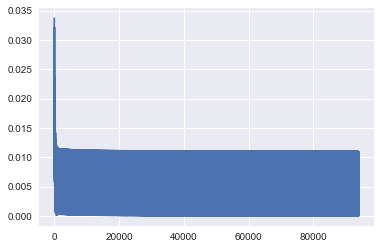

In [78]:
print(len(test_loss))
#plt.plot(test_loss)
plt.plot(train_loss,'-')
#plt.ylim([0.000,0.99])


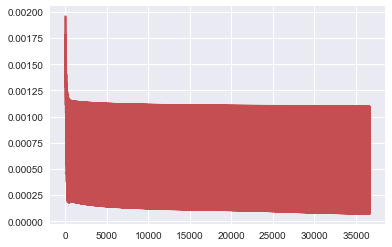

In [79]:
plt.plot(test_loss,'r')

#### Demornamization

In [80]:
rmse = np.sqrt(mse)

In [81]:
rmse_denorm = (rmse * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()

In [82]:
rmse_denorm

9.769484181106005

In [83]:
df_new_test['Kt'].describe()

count    3915.000000
mean        3.727410
std        18.112833
min        -0.025284
25%         0.000251
50%         0.270952
75%         1.258475
max       653.281210
Name: Kt, dtype: float64

### Saving train and test losses to a csv

In [84]:
df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss, 'iteration': train_iter}, columns=['Train Loss','iteration'])
df_trainLoss.to_csv('RNN Paper Results/Exp1_PennState_TrainLoss.csv')
df_testLoss = pd.DataFrame(data={'Test Loss':test_loss, 'iteration': test_iter}, columns=['Test Loss','iteration'])
df_testLoss.to_csv('RNN Paper Results/Exp1_PenState_TestLoss.csv')